# 096291 - Algorithmic and High-Frequency Trading - Final Project

In [1108]:
# Import libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Set plot properties
plt.matplotlib.rc('grid', linestyle='dashed', linewidth=1, alpha=0.25)
plt.matplotlib.rc('font', family='serif', size=12)
plt.matplotlib.rc('legend', fontsize=12)
plt.rcParams.update({'text.usetex': True})

### Functions for generating noise processes

In [955]:
def generate_standard_brownian_motion(dt=1e-2):
    """Generates standard Brownian motion with given time interval."""
    N = round(1 / dt)
    W = np.zeros(N + 1)
    W[1:] = np.random.normal(0, np.sqrt(dt), N)  # White Gaussian noise
    W = np.cumsum(W)
    return W

def generate_mean_reverting_jump(dt=1e-4, lmbda=10, kappa=10, eta0=1, single=True):
    """Generates an Ornstein–Uhlenbeck (OU) process fed by a Poisson point process.
    The "jumps" are approximated by a Bernoulli process with the appropriate sucess probability.
    """
    N = round(1 / dt)
    p = lmbda * dt  # Effective success probability
    jump_locs = np.random.binomial(1, p, size=(N+1,))
    t = np.arange(0, 1 + dt, dt)  
    jumps = t[jump_locs == 1]
    t_jump_diff = t - jumps.reshape(-1, 1)
    if single:
        eta = np.random.exponential(eta0)
        L = eta * np.exp(-kappa * t_jump_diff)
    else:
        etas = np.random.exponential(eta0, size=(len(jumps),))
        L = etas.reshape(-1, 1) * np.exp(-kappa * t_jump_diff)
    L *= (t_jump_diff >= 0)
    L = L.sum(axis=0)
    return L

## Problem 1 - Incorporating Order Flow

### Auxiliary parameters

In [797]:
def calc_gamma(phi, k):
    return np.sqrt(phi / k)

def calc_zeta(alpha, b, phi, k):
    ab = alpha - 0.5 * b
    pk = np.sqrt(k * phi)
    return (ab + pk) / (ab - pk)

### Optimal strategies

In [503]:
def optimal_rate_no_order_flow(t, gamma, zeta):
    """Computes optimal trading rate without incorporating order flow imbalance, assuming an initial inventory of size 1."""
    tau = 1 - t  # Time until maturity
    return gamma * (zeta * np.exp(gamma * tau) + np.exp(-gamma * tau)) / (zeta * np.exp(gamma) - np.exp(-gamma))

def l(tau, gamma, zeta, kappa):
    """Computes the function l(tau) as defined in the PDF."""
    return (np.exp(gamma * tau) * (1 - np.exp(-(kappa + gamma) * tau)) / (kappa + gamma) * zeta
          - np.exp(-gamma * tau) * (1 - np.exp(-(kappa - gamma) * tau)) / (kappa - gamma)) / (zeta * np.exp(gamma * tau) - np.exp(-gamma * tau))

def optimal_rate_order_flow(t, Q, mu, b, k, gamma, zeta, kappa):
    """Computes optimal trading rate with incorporating order flow imbalance."""
    tau = 1 - t  # Time until maturity 
    rate_orig = gamma * (zeta * np.exp(gamma * tau) + np.exp(-gamma * tau)) / (zeta * np.exp(gamma * tau) - np.exp(-gamma * tau)) * Q
    rate_order_flow = - b / (2 * k) * l(1 - t, gamma, zeta, kappa) * mu
    return rate_orig + rate_order_flow

### Simulation 1 - Multiple realizations

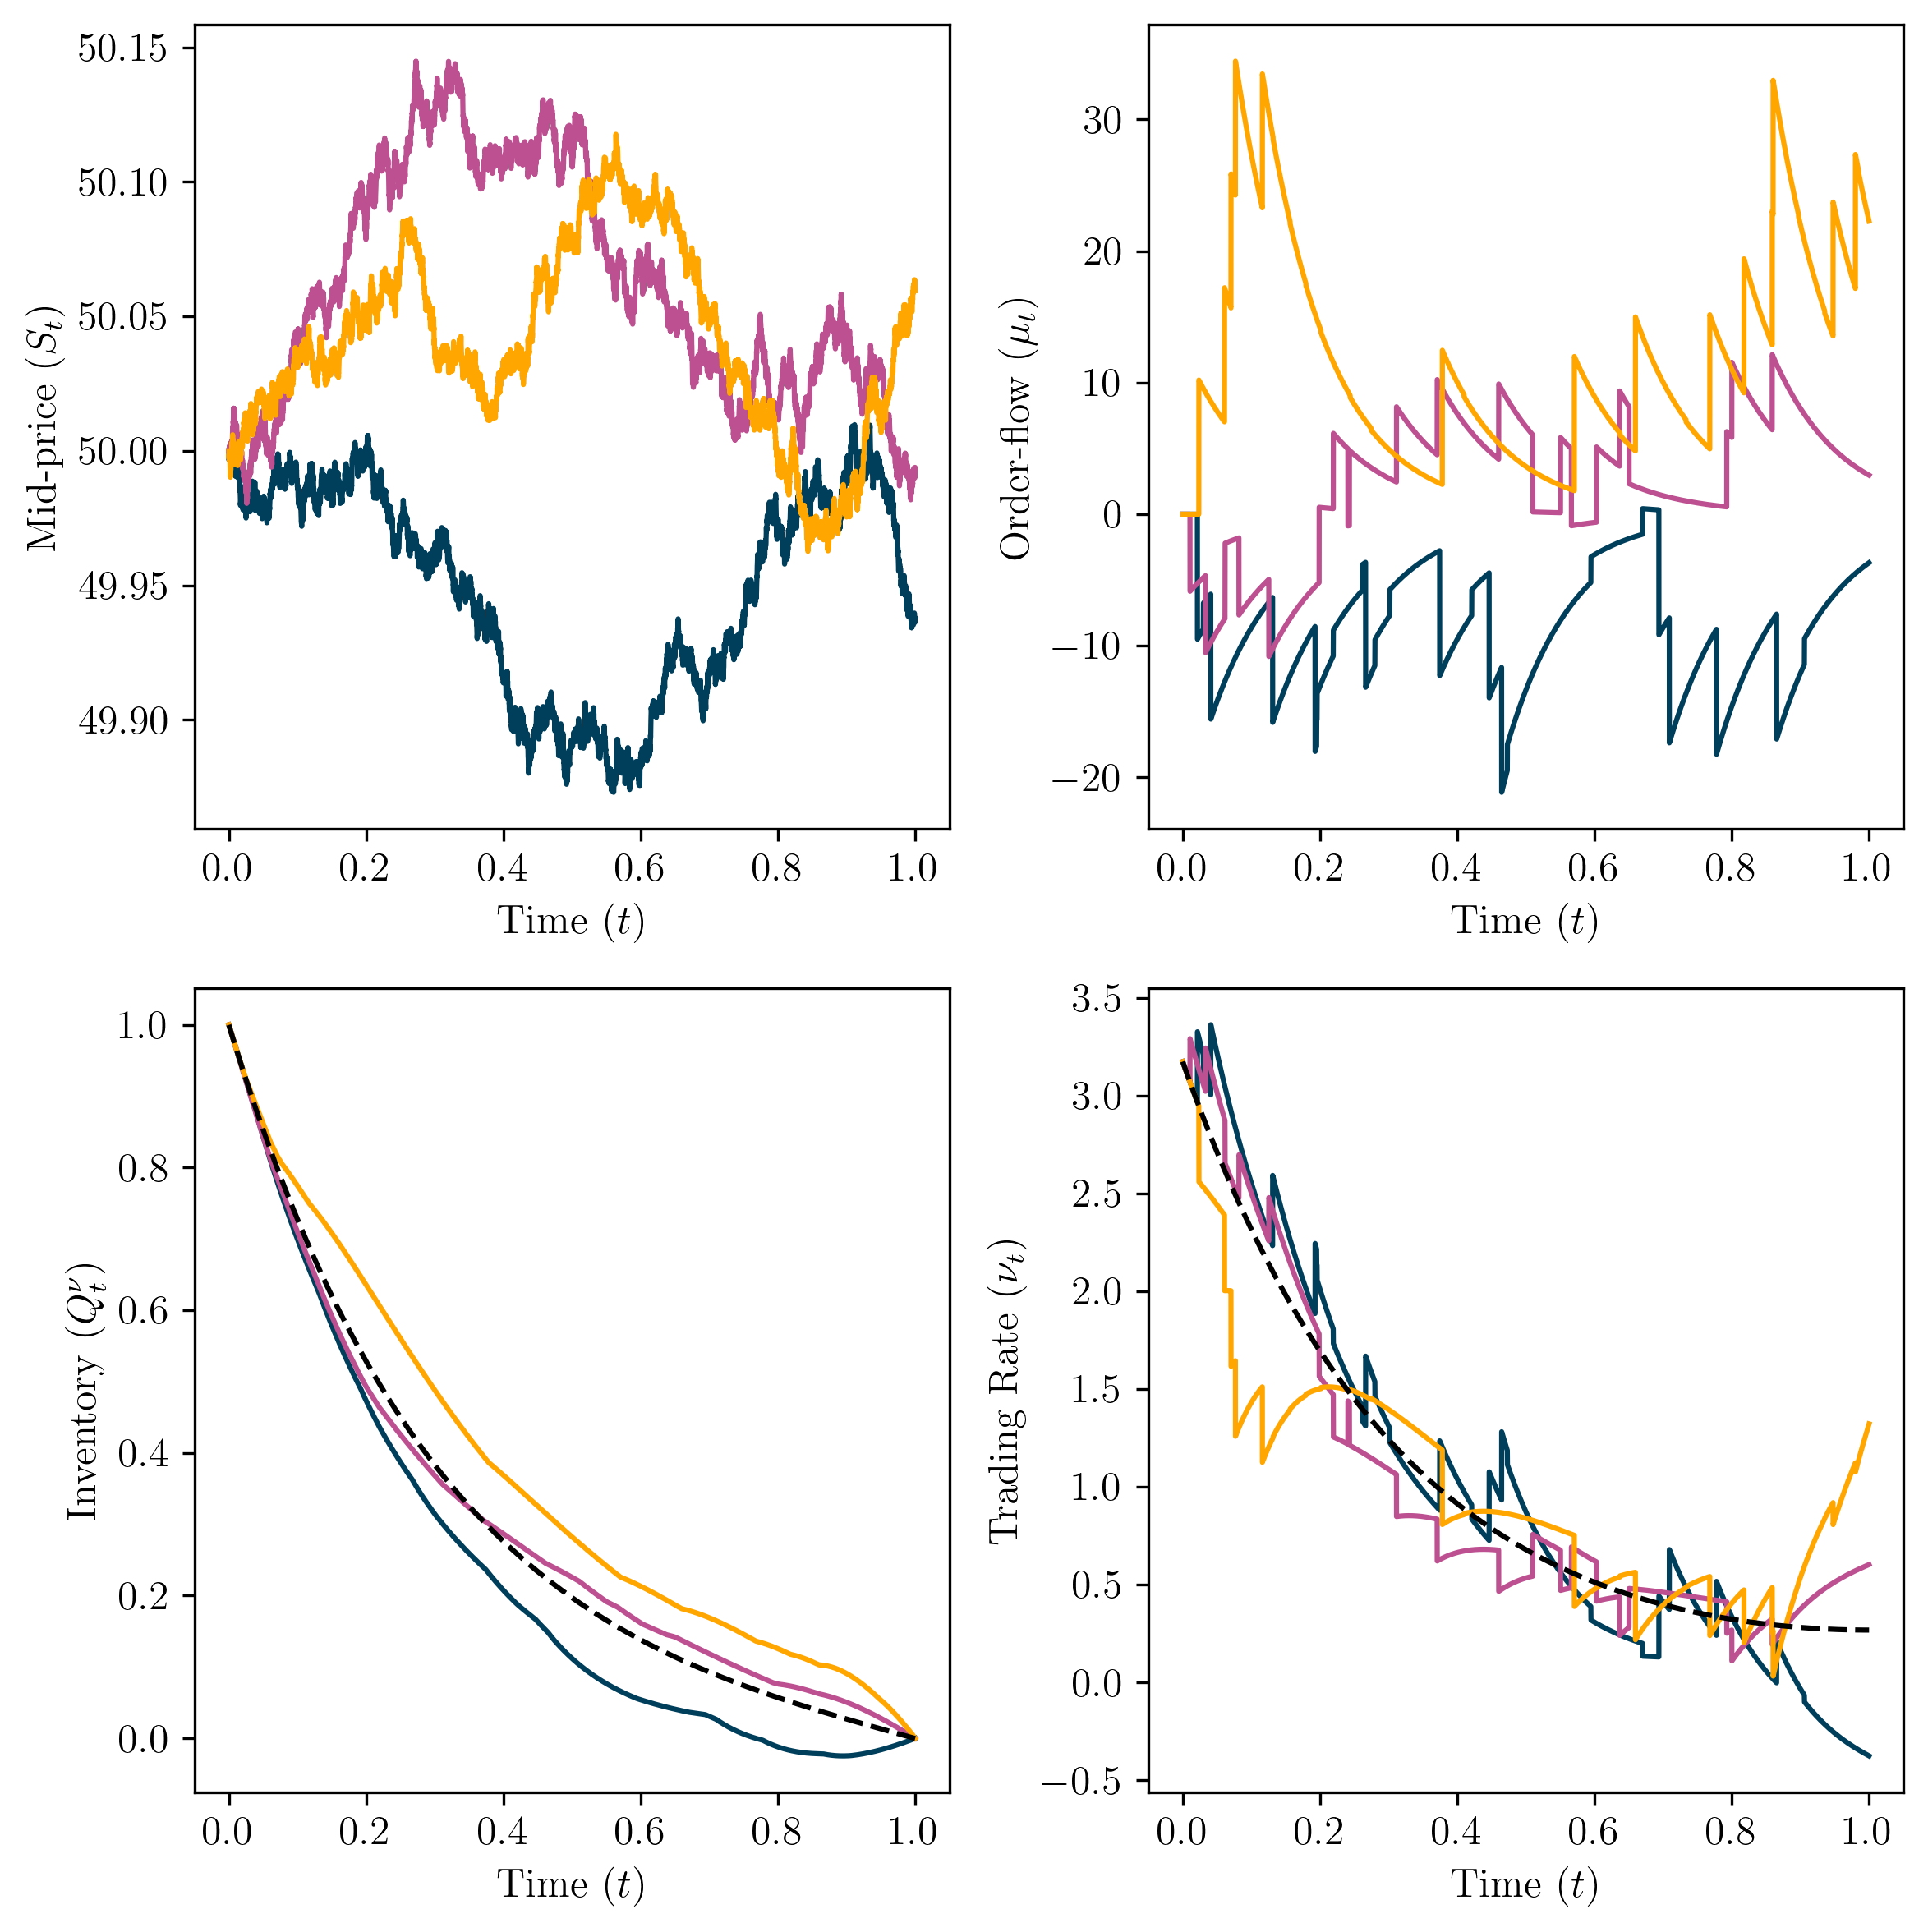

In [889]:
dt = 1e-4  # Time interval
N = round(1 / dt) + 1  # Number of elements
S0 = 50  # Initial asset price
sigma = 0.1  # Price volatility
alpha = 1e6  # Terminal penalty coefficient
phi = 1e-2  # Inventory penalty coefficient
k = 1e-3  # Temporary market impact
b = 1e-3  # Permanent market impact
lmbda = 10  # Order flow rate parameter
kappa = 10  # Mean reversion rate
eta0 = 5  # Expected order flow magnitude

# Auxiliary parameters
gamma = calc_gamma(phi, k)
zeta = calc_zeta(alpha, b, phi, k)

t = np.arange(0, 1 + dt, dt)
S_lst, mu_lst, Q_lst, nu_lst = [], [], [], []

# Optimal trading rate without incorporating order flow
nu_orig = optimal_rate_no_order_flow(t, gamma, zeta)
Q_orig = 1 - np.cumsum(nu_orig) * dt

num_samples = 3
for i in range(num_samples):
    # Generate noise processes
    W = generate_standard_brownian_motion(dt)
    mu_plus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=True)
    mu_minus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=True)
    mu = mu_plus - mu_minus
    
    # Compute state and control processes
    nu, Q = np.zeros(N), np.zeros(N)
    Q[0] = 1
    for j in range(N - 1):
        nu[j] = optimal_rate_order_flow(t[j], Q[j], mu[j], b, k, gamma, zeta, kappa)
        Q[j + 1] = Q[j] - nu[j] * dt
    nu[-1] = nu[-2]
    S = S0 + sigma * W + b * np.cumsum(mu - nu) * dt

    # Append processes to lists
    S_lst.append(S)
    mu_lst.append(mu)
    Q_lst.append(Q)
    nu_lst.append(nu)

# Visualize results
colors = ['#003f5c', '#bc5090', '#ffa600']
fig = plt.figure(figsize=(8, 8), dpi=300)
axes = fig.subplots(2, 2)
ax1, ax2, ax3, ax4 = axes.flatten()
for i, S, mu, Q, nu in zip(range(num_samples), S_lst, mu_lst, Q_lst, nu_lst):
    ax1.plot(t, S, color=colors[i])
    ax2.plot(t, mu, color=colors[i])
    ax3.plot(t, Q, color=colors[i])
    ax4.plot(t, nu, color=colors[i])
ax3.plot(t, Q_orig, linestyle='--', color='k')
ax4.plot(t, nu_orig, linestyle='--', color='k')
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('Time ($t$)')
ax1.set_ylabel('Mid-price ($S_t$)')
ax2.set_ylabel('Order-flow ($\mu_t$)')
ax3.set_ylabel('Inventory ($Q_t^{\\nu}$)')
ax4.set_ylabel('Trading Rate ($\\nu_t$)')
plt.tight_layout()
fig.savefig('fig_1_1.svg')
plt.show()

### Simulation 2 - Multiple volatility levels and mean-reversion rates

C:\Users\matan\AppData\Local\Temp/ipykernel_29912/790614841.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig1.tight_layout()
C:\Users\matan\AppData\Local\Temp/ipykernel_29912/790614841.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig2.tight_layout()
C:\Users\matan\AppData\Local\Temp/ipykernel_29912/790614841.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig1.savefig('fig_1_2.svg')
C:\Users\matan\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


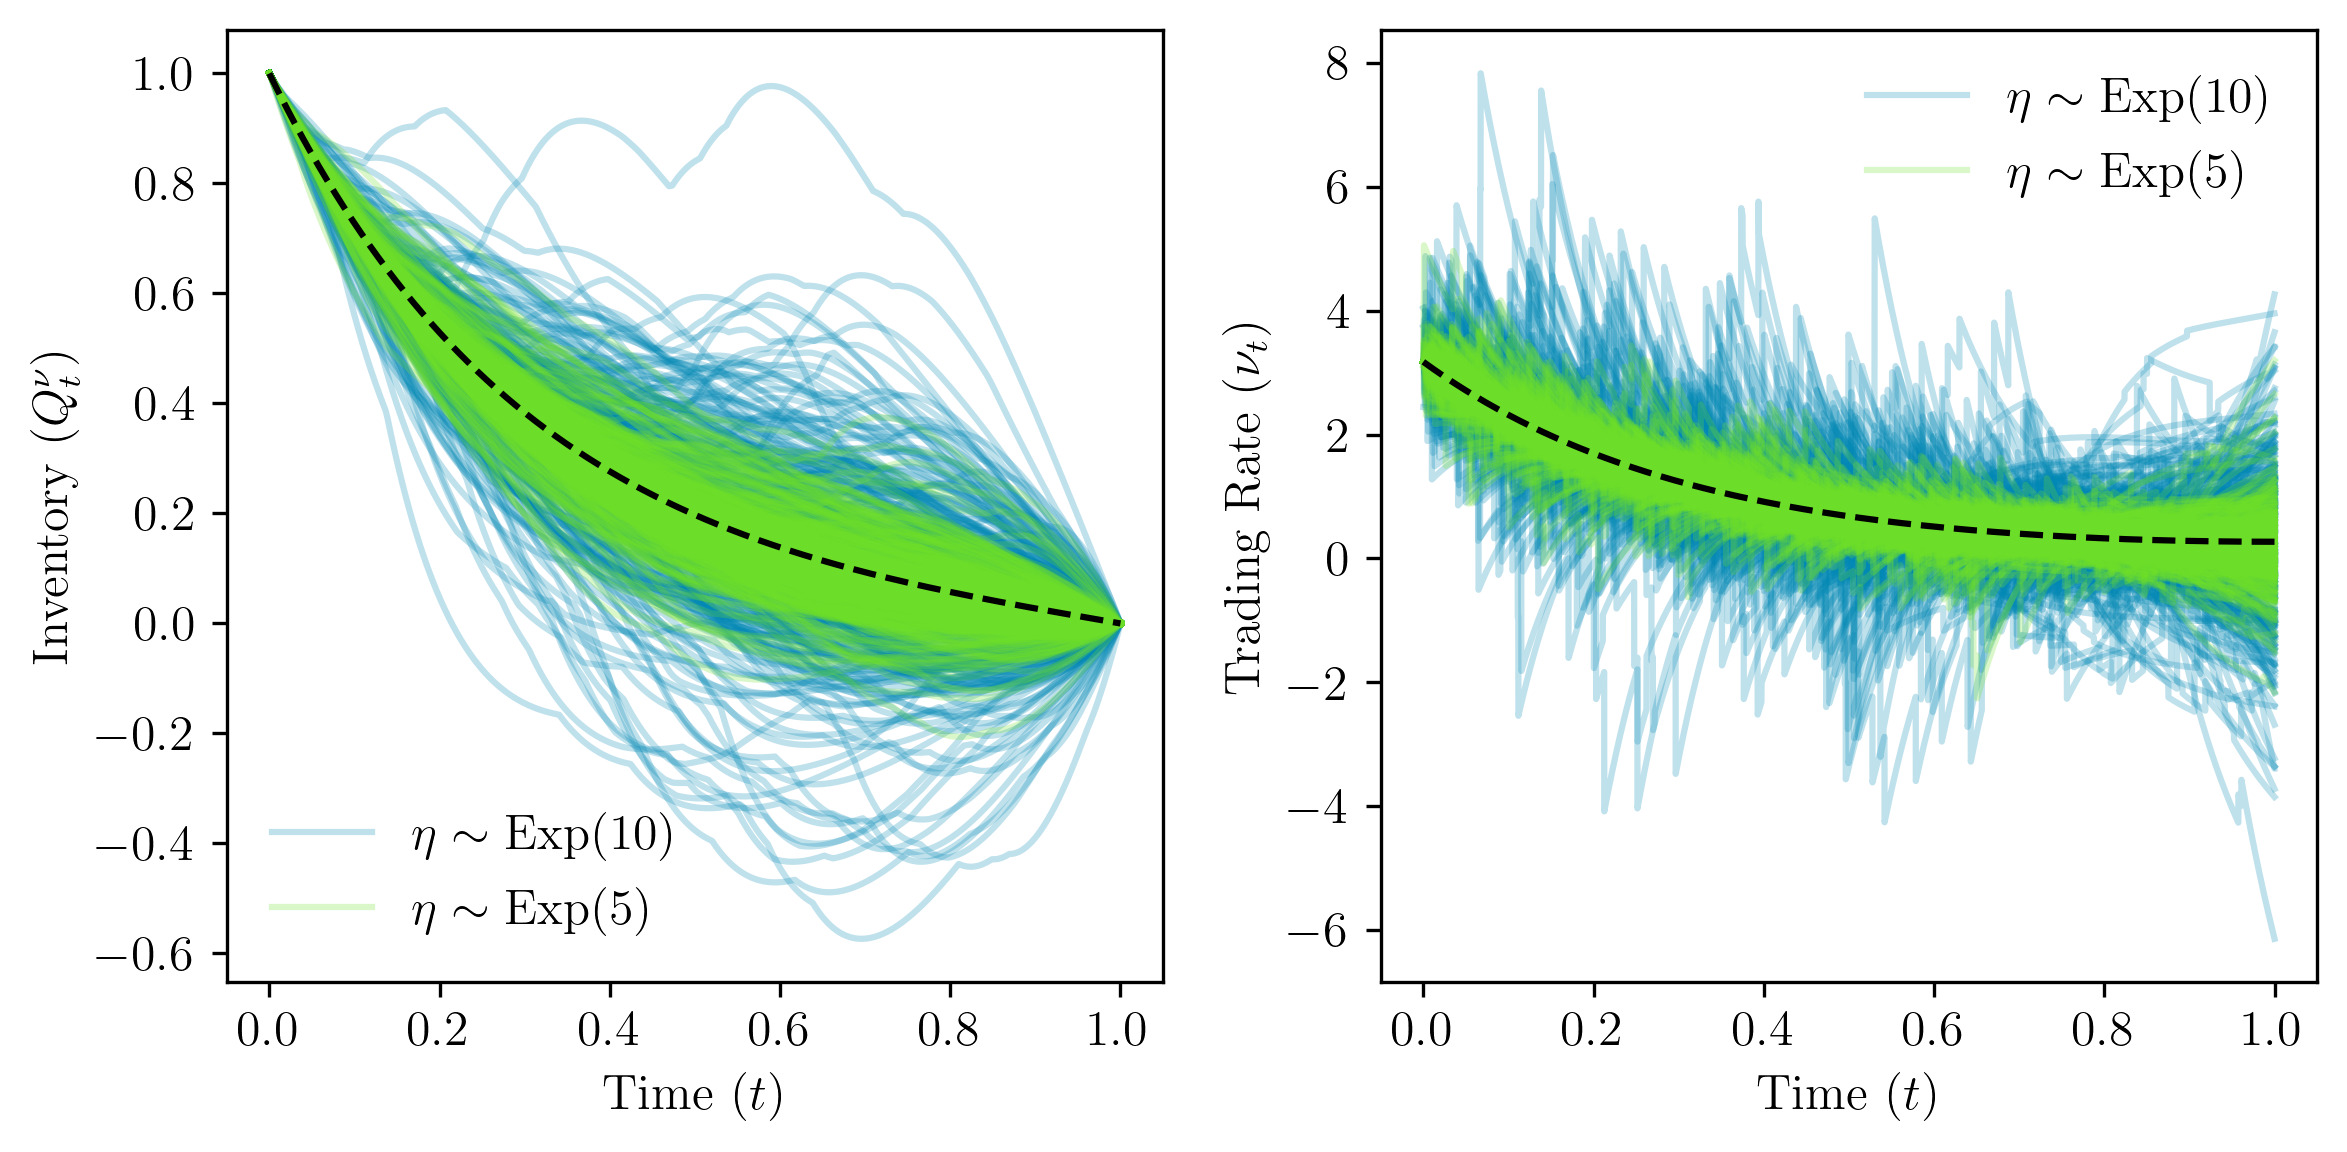

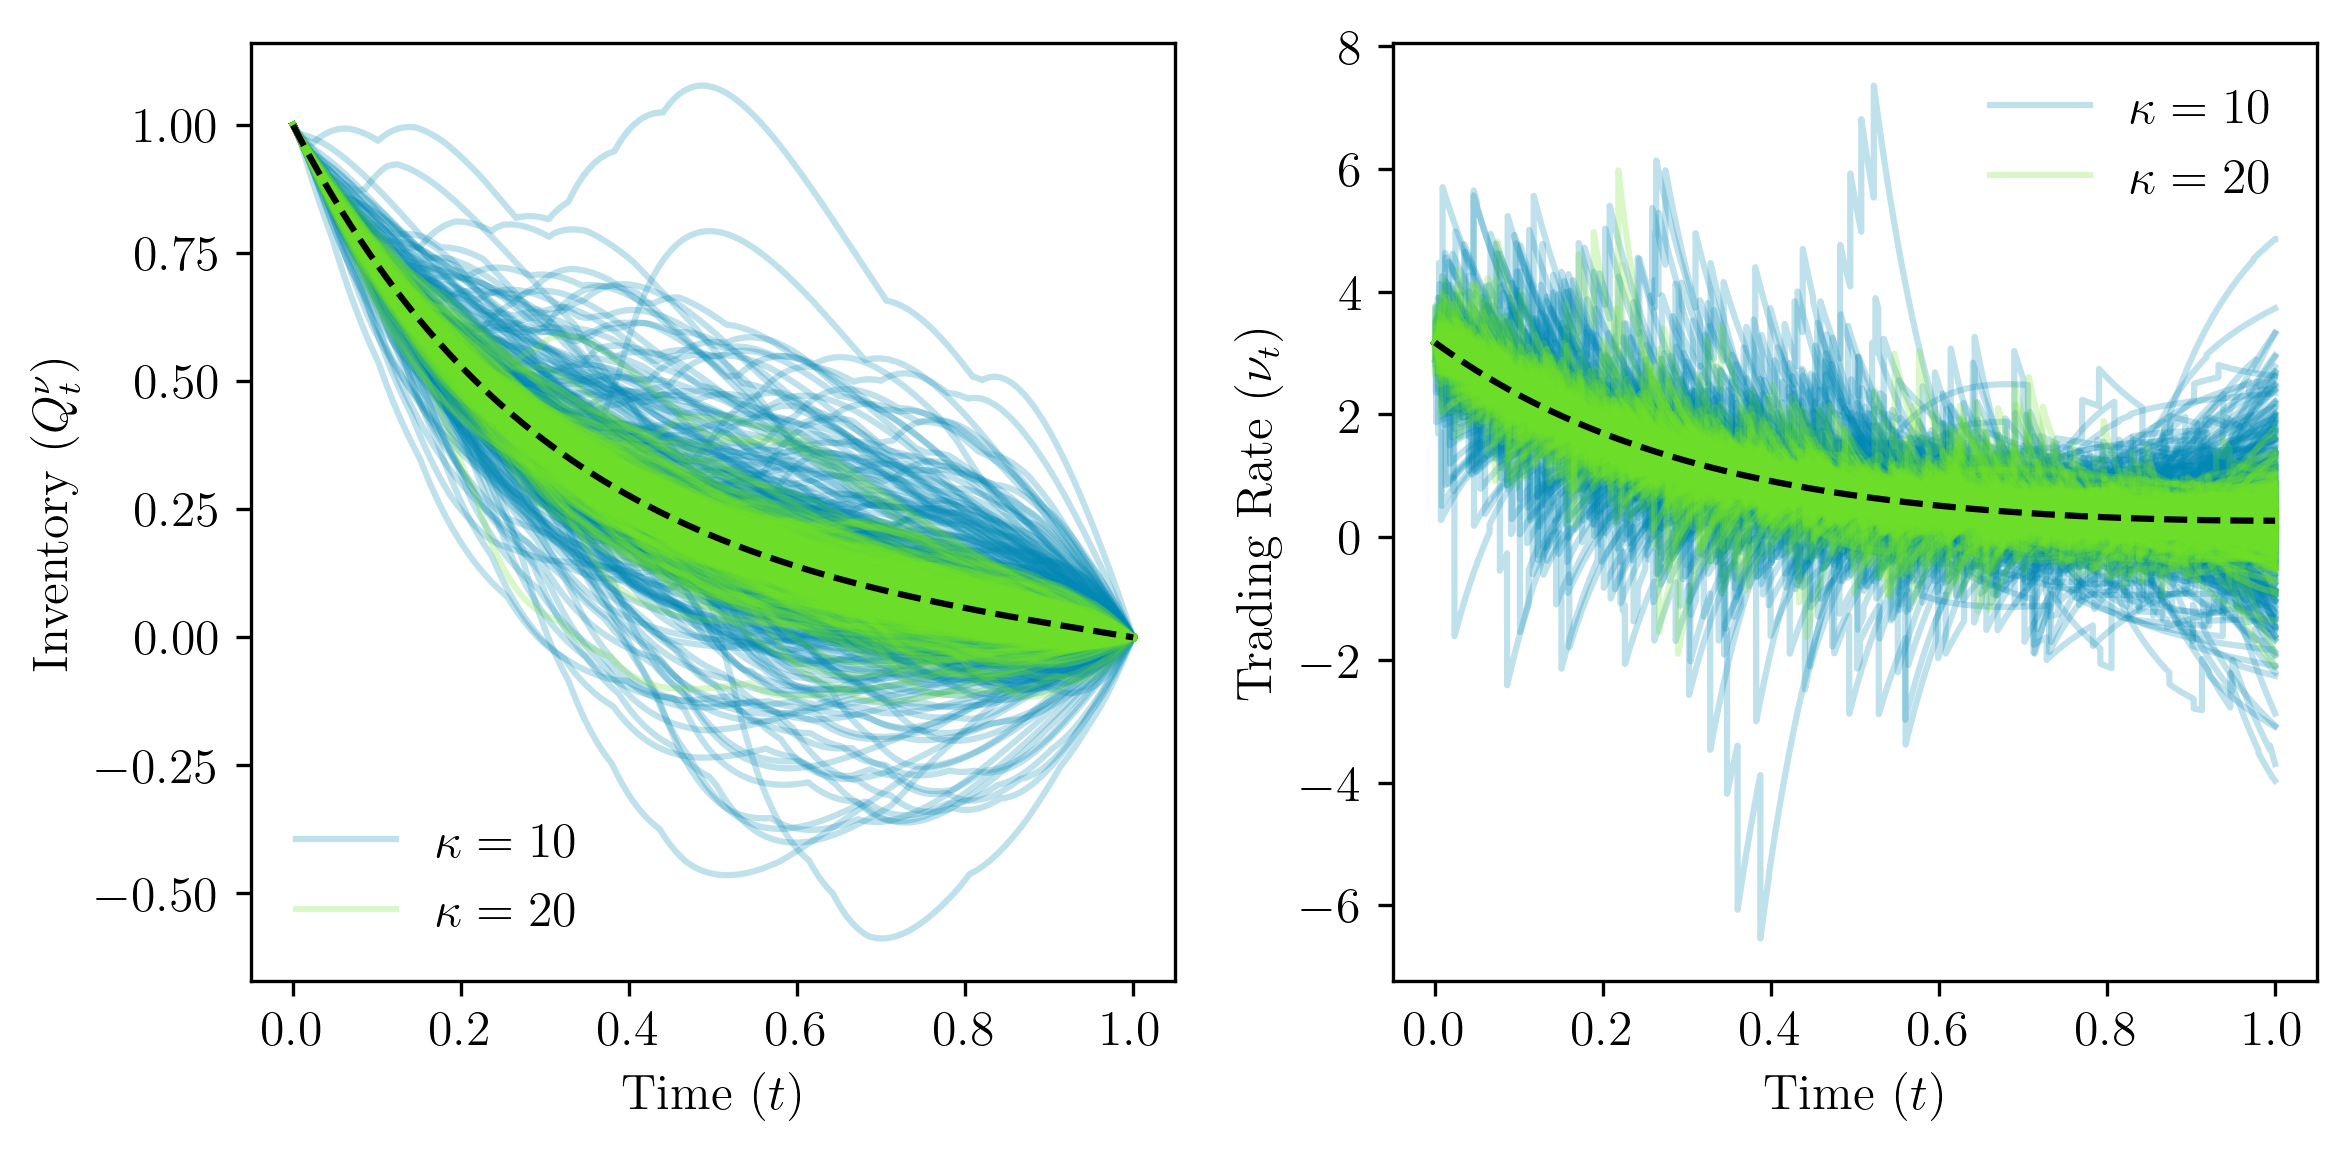

In [859]:
dt = 1e-4  # Time interval
N = int(1 / dt) + 1  # Number of elements
S0 = 50  # Initial asset price
sigma = 0.1  # Price volatility
alpha = 1e6  # Terminal penalty coefficient
phi = 1e-2  # Inventory penalty coefficient
k = 1e-3  # Temporary market impact
b = 1e-3  # Permanent market impact
lmbda = 10  # Order flow rate parameter
kappa_lst = [10, 10, 10, 20]  # Mean reversion rate
eta0_lst = [10, 5, 10, 10]  # Expected order flow magnitude

# Auxiliary parameters
gamma = calc_gamma(phi, k)
zeta = calc_zeta(alpha, b, phi, k)

t = np.arange(0, 1 + dt, dt)

# Optimal trading rate without incorporating order flow
nu_orig = optimal_rate_no_order_flow(t, gamma, zeta)
Q_orig = 1 - np.cumsum(nu_orig) * dt

# Initialize figures
colors = ['#0088b5', '#6fe028']
fig1 = plt.figure(figsize=(8, 4), dpi=300)
fig2 = plt.figure(figsize=(8, 4), dpi=300)
ax11, ax12 = fig1.subplots(1, 2)
ax21, ax22 = fig2.subplots(1, 2)

num_samples = 500
for idx, kappa, eta0 in zip(range(len(kappa_lst)), kappa_lst, eta0_lst):
    for i in range(num_samples):
        # Generate noise processes
        W = generate_standard_brownian_motion(dt)
        mu_plus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=True)
        mu_minus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=True)
        mu = mu_plus - mu_minus

        # Compute state and control processes
        nu, Q = np.zeros(N), np.zeros(N)
        Q[0] = 1
        for j in range(N - 1):
            nu[j] = optimal_rate_order_flow(t[j], Q[j], mu[j], b, k, gamma, zeta, kappa)
            Q[j + 1] = Q[j] - nu[j] * dt
        nu[-1] = nu[-2]
        S = S0 + sigma * W + b * np.cumsum(mu - nu) * dt

        # Plot results
        if idx < 2:
            if i == 0:
                ax11.plot(t, Q, color=colors[idx], alpha=0.25, label=f'$\eta \sim \mathrm{{Exp}}({eta0})$')
                ax12.plot(t, nu, color=colors[idx], alpha=0.25, label=f'$\eta \sim \mathrm{{Exp}}({eta0})$')
            else:
                ax11.plot(t, Q, color=colors[idx], alpha=0.25)
                ax12.plot(t, nu, color=colors[idx], alpha=0.25)
        else:
            if i == 0:
                ax21.plot(t, Q, color=colors[idx - 2], alpha=0.25, label=f'$\kappa={kappa}$')
                ax22.plot(t, nu, color=colors[idx - 2], alpha=0.25, label=f'$\kappa={kappa}$')
            else:
                ax21.plot(t, Q, color=colors[idx - 2], alpha=0.25)
                ax22.plot(t, nu, color=colors[idx - 2], alpha=0.25)
            
# Visualize results
ax11.plot(t, Q_orig, linestyle='--', color='k')
ax12.plot(t, nu_orig, linestyle='--', color='k')
ax21.plot(t, Q_orig, linestyle='--', color='k')
ax22.plot(t, nu_orig, linestyle='--', color='k')
for ax in [ax11, ax12, ax21, ax22]:
    ax.set_xlabel('Time ($t$)')
ax11.set_ylabel('Inventory ($Q_t^{\\nu}$)')
ax12.set_ylabel('Trading Rate ($\\nu_t$)')
ax21.set_ylabel('Inventory ($Q_t^{\\nu}$)')
ax22.set_ylabel('Trading Rate ($\\nu_t$)')
ax11.legend(frameon=False)
ax12.legend(frameon=False)
ax21.legend(frameon=False)
ax22.legend(frameon=False)
fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('fig_1_2.svg')
fig2.savefig('fig_1_3.svg')
plt.show()

### Simulation 3 - Comparing profits obtained by the various strategies

Standard strategy: 0.006182±0.041982
Constrained strategy: 0.021039±0.065521
Optimal strategy: 0.023809±0.092144


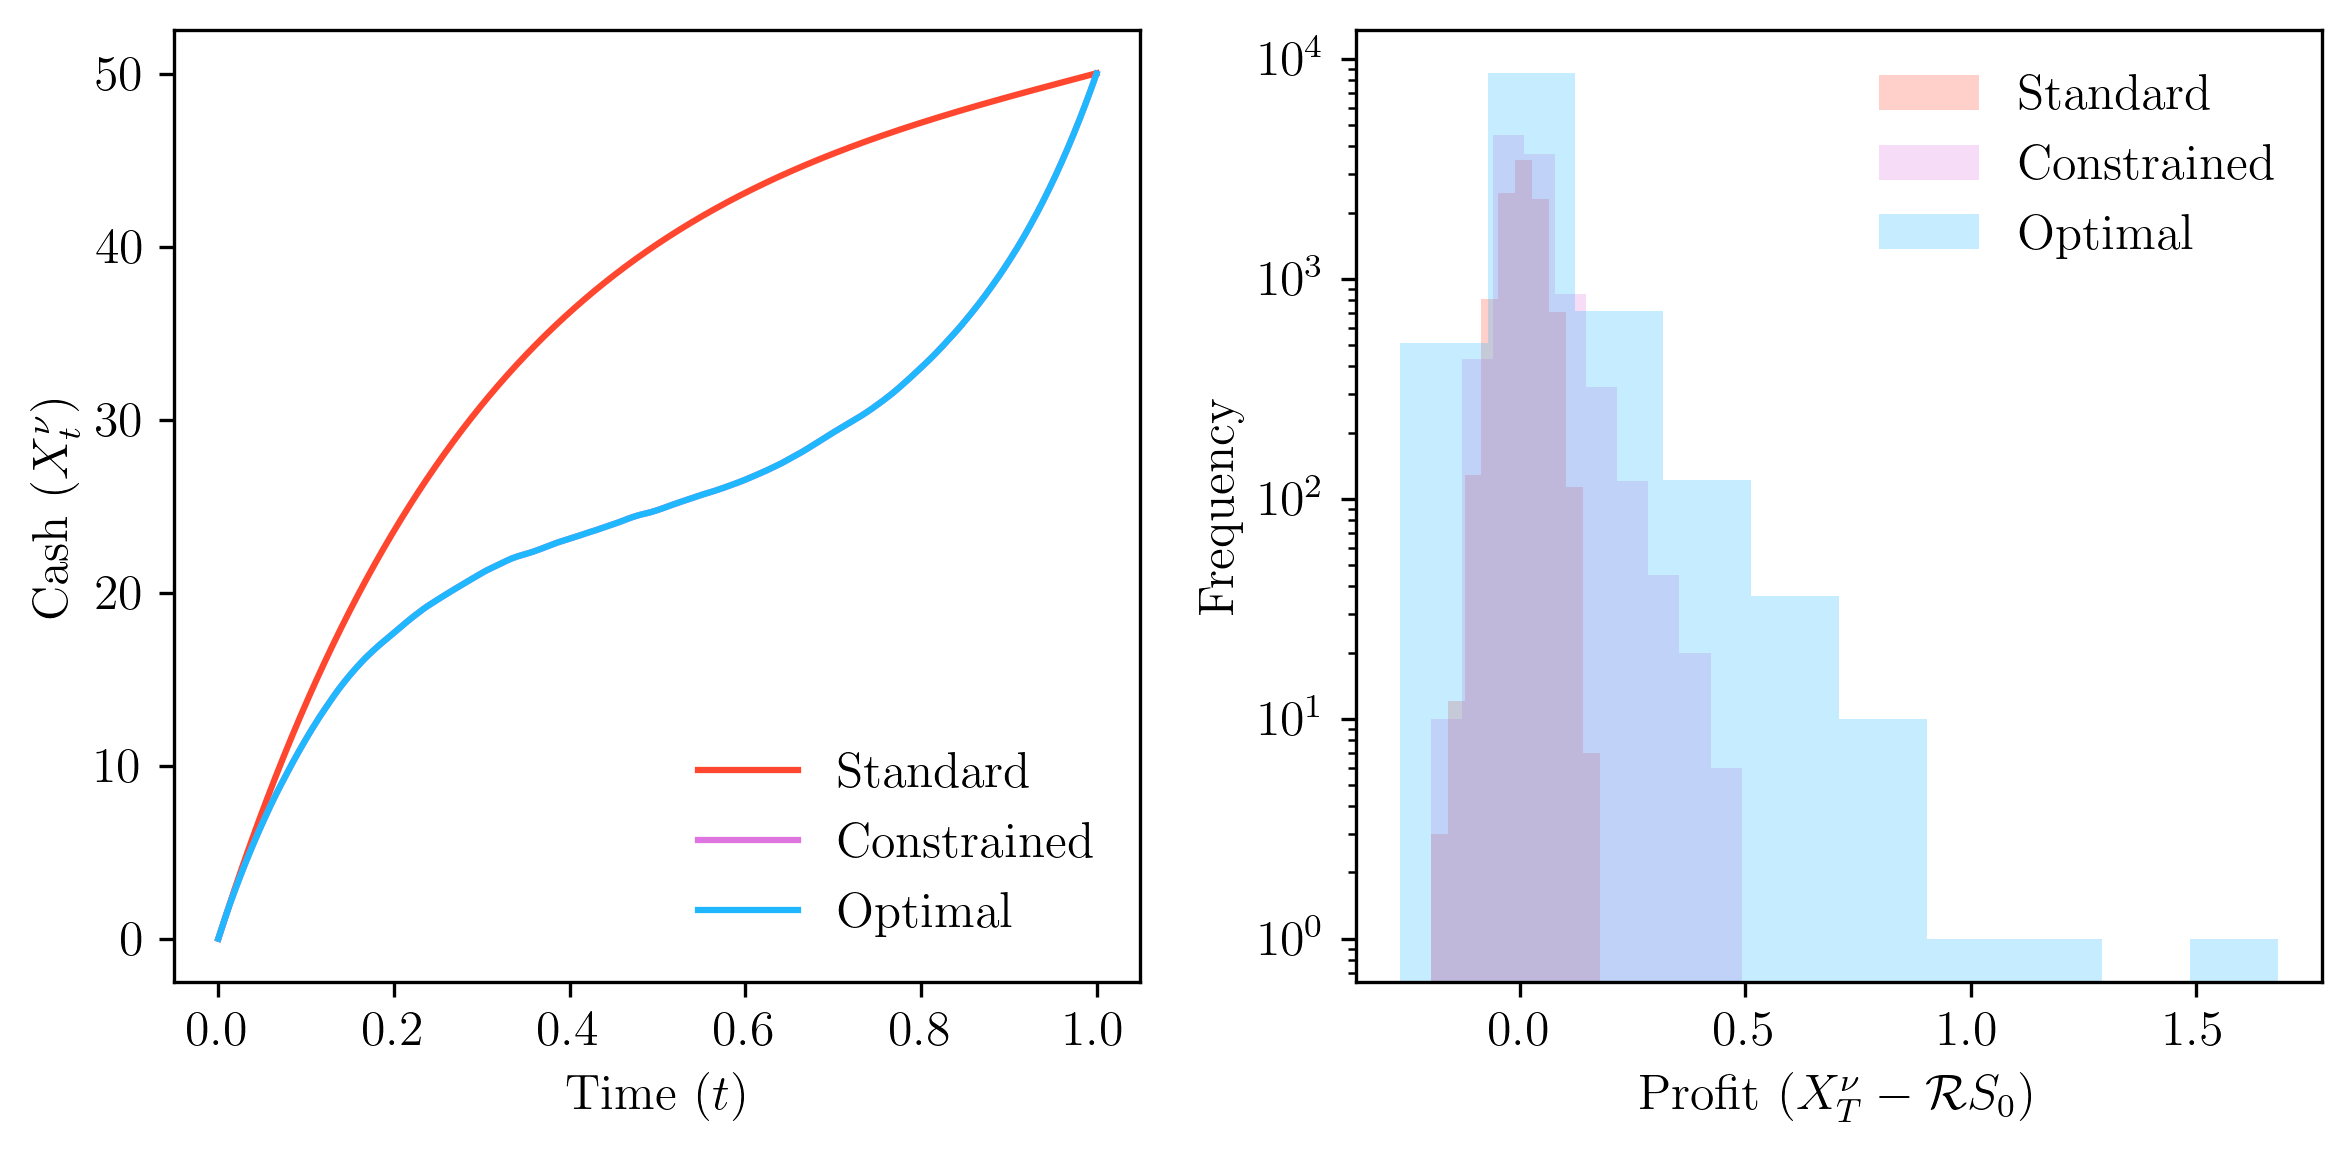

In [1205]:
dt = 1e-4  # Time interval
N = round(1 / dt) + 1  # Number of elements
S0 = 50  # Initial asset price
sigma = 0.1  # Price volatility
alpha = 1e6  # Terminal penalty coefficient
phi = 1e-2  # Inventory penalty coefficient
k = 1e-3  # Temporary market impact
b = 1e-4  # Permanent market impact
lmbda = 1000  # Order flow rate parameter
kappa = 10  # Mean reversion rate
eta0 = 5  # Expected order flow magnitude

# Auxiliary parameters
gamma = calc_gamma(phi, k)
zeta = calc_zeta(alpha, b, phi, k)

t = np.arange(0, 1 + dt, dt)
P_orig_lst, P_naive_lst, P_opt_lst = [], [], []

# Optimal trading rate without incorporating order flow
nu_orig = optimal_rate_no_order_flow(t, gamma, zeta)

# Initialize figure
colors = ['#ff462e', '#dd74df', '#1fb8ff']
fig = plt.figure(figsize=(8, 4), dpi=300)
ax1, ax2 = fig.subplots(1, 2)

num_samples = 10**4
for i in range(num_samples):
    # Generate noise processes
    W = generate_standard_brownian_motion(dt)
    mu_plus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=True)
    mu_minus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=True)
    mu = mu_plus - mu_minus

    # Compute state and control processes
    nu, Q = np.zeros(N), np.zeros(N)
    nu_naive, Q_naive = np.zeros(N), np.zeros(N)
    Q[0] = 1
    Q_naive[0] = 1
    for j in range(N - 1):
        # Unconstrained strategy
        nu[j] = optimal_rate_order_flow(t[j], Q[j], mu[j], b, k, gamma, zeta, kappa)
        Q[j + 1] = Q[j] - nu[j] * dt
        
        # Strategy constrained to positive inventory and trading rate
        nu_naive[j] = optimal_rate_order_flow(t[j], Q_naive[j], mu[j], b, k, gamma, zeta, kappa)
        nu_naive[j] = np.maximum(nu_naive[j], 0) * (Q_naive[j] > 0)
        Q_naive[j + 1] = Q_naive[j] - nu_naive[j] * dt
        
    nu[-1] = nu[-2]
    nu_naive[-1] = nu_naive[-2]
    S = S0 + sigma * W + b * np.cumsum(mu - nu) * dt
    S_orig = S0 + sigma * W + b * np.cumsum(mu - nu_orig) * dt
    S_naive = S0 + sigma * W + b * np.cumsum(mu - nu_naive) * dt
    
    # Compute cash process for the various strategies
    X_orig = np.cumsum((S_orig - k * nu_orig) * nu_orig) * dt
    X_naive = np.cumsum((S_naive - k * nu_naive) * nu_naive) * dt
    X_opt = np.cumsum((S - k * nu) * nu) * dt
    
    # Append profits to lists
    P_orig_lst.append(X_orig[-1] - S0)
    P_naive_lst.append(X_naive[-1] - S0)
    P_opt_lst.append(X_opt[-1] - S0)
    
    # Plot cash processes for a specific realization
    if i == 0:
        ax1.plot(t, X_orig, color=colors[0], label='Standard')
        ax1.plot(t, X_naive, color=colors[1], label='Constrained')
        ax1.plot(t, X_opt, color=colors[2], label='Optimal')

# Print mean±std of profit for each strategy
print(f'Standard strategy: {np.array(P_orig_lst).mean():.6f}±{np.array(P_orig_lst).std():.6f}')
print(f'Constrained strategy: {np.array(P_naive_lst).mean():.6f}±{np.array(P_naive_lst).std():.6f}')
print(f'Optimal strategy: {np.array(P_opt_lst).mean():.6f}±{np.array(P_opt_lst).std():.6f}')
        
# Visualize results
ax2.hist(P_orig_lst, color=colors[0], alpha=0.25, label='Standard')
ax2.hist(P_naive_lst, color=colors[1], alpha=0.25, label='Constrained')
ax2.hist(P_opt_lst, color=colors[2], alpha=0.25, label='Optimal')
ax1.set_xlabel('Time ($t$)')
ax1.set_ylabel('Cash ($X_t^{\\nu}$)')
ax1.legend(frameon=False)
ax2.set_yscale('log')
ax2.set_xlabel('Profit ($X_T^{\\nu} - \mathcal{R}S_0$)')
ax2.set_ylabel('Frequency')
ax2.legend(frameon=False)
plt.tight_layout()
fig.savefig('fig_1_4.svg')
plt.show()

## Problem 2 - Including Impact of Other Traders

### Auxiliary parameters

In [908]:
def calc_zeta2(alpha, b, phi, k):
    return (k + phi) / (alpha - 0.5 * b)

### Optimal strategies

In [1004]:
def optimal_rate_no_impact(t, Q, mu_minus, rho, lmbda, b, phi, k, zeta, kappa, eta0):
    """Computes optimal trading rate without incorporating impact from other traders."""
    tau = 1 - t  # Time until maturity 
    vol_term = phi / (k + phi) * rho * mu_minus
    twap_term = (Q / (tau + zeta) - phi / (k + phi) * rho * (kappa * lmbda * eta0 * tau
                + (kappa * mu_minus - lmbda * eta0) * (1 - np.exp(-kappa * tau))) / (kappa ** 2 * (tau + zeta)))
    return vol_term + twap_term

def optimal_rate_impact(t, Q, mu_minus, mu, rho, lmbda, b, phi, k, zeta, kappa, eta0):
    """Computes optimal trading rate incorporating impact from other traders."""
    tau = 1 - t  # Time until maturity 
    orig_term = optimal_rate_no_impact(t, Q, mu_minus, rho, lmbda, b, phi, k, zeta, kappa, eta0)  # Strategy without impact
    impact_term = -b / (2 * (k + phi)) * (kappa * tau - (1 - kappa * zeta) * (1 - np.exp(-kappa * tau))) / (kappa ** 2 * (tau + zeta)) * mu
    return orig_term + impact_term

### Simulation 1 - Multiple realizations

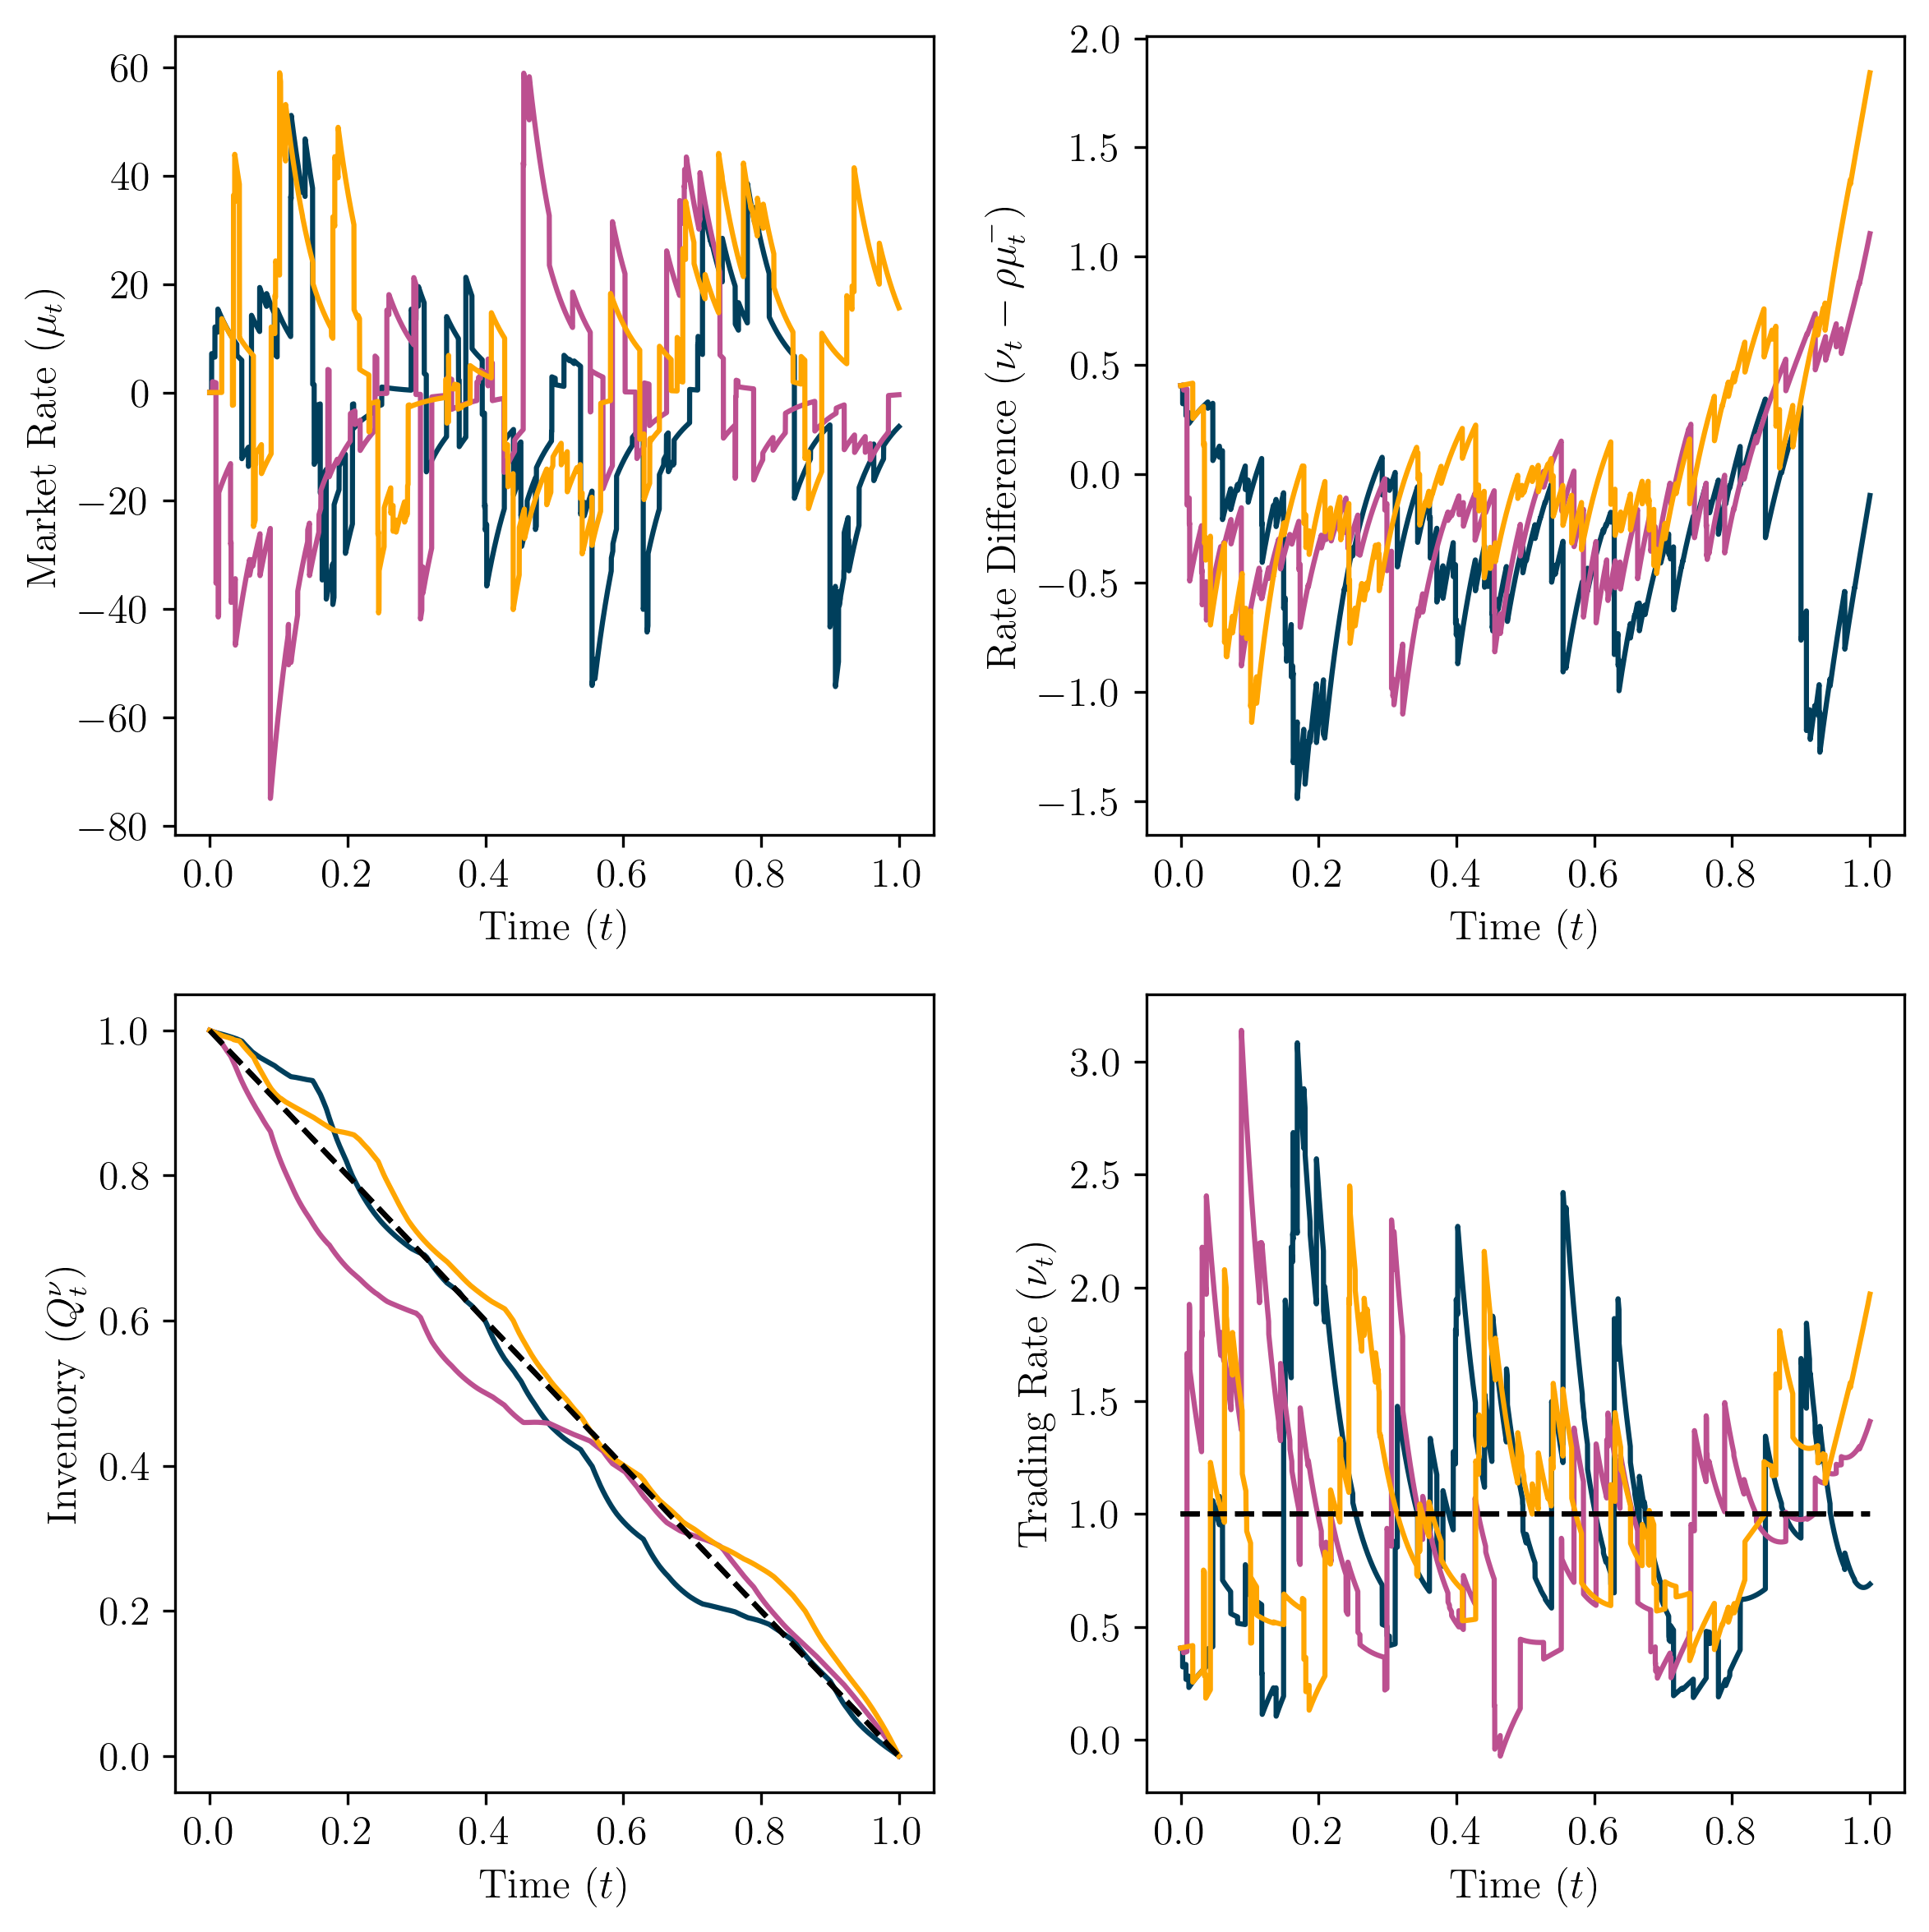

In [1095]:
dt = 1e-4  # Time interval
N = round(1 / dt) + 1  # Number of elements
S0 = 50  # Initial asset price
sigma = 0.5  # Price volatility
alpha = 1e6  # Terminal penalty coefficient
phi = 0.1  # Volume penalty coefficient
k = 0.1  # Temporary market impact
b = 0.1  # Permanent market impact
rho = 0.05  # Percentage of market volume to target
lmbda = 50  # Order flow rate parameter
kappa = 20  # Mean reversion rate
eta0 = 10  # Expected order flow magnitude

# Auxiliary parameters
zeta = calc_zeta2(alpha, b, phi, k)

t = np.arange(0, 1 + dt, dt)
mu_minus_lst, mu_lst, Q_lst, nu_lst = [], [], [], []

num_samples = 3
for i in range(num_samples):
    # Generate noise processes
    W = generate_standard_brownian_motion(dt)
    mu_plus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=False)
    mu_minus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=False)
    mu = mu_plus - mu_minus
    
    # Compute state and control processes
    nu, Q = np.zeros(N), np.zeros(N)
    Q[0] = 1
    for j in range(N - 1):
        nu[j] = optimal_rate_impact(t[j], Q[j], mu_minus[j], mu[j], rho, lmbda, b, phi, k, zeta, kappa, eta0)
        Q[j + 1] = Q[j] - nu[j] * dt
    nu[-1] = nu[-2]

    # Append processes to lists    
    mu_minus_lst.append(mu_minus)
    mu_lst.append(mu)
    Q_lst.append(Q)
    nu_lst.append(nu)

# Visualize results
colors = ['#003f5c', '#bc5090', '#ffa600']
fig = plt.figure(figsize=(8, 8), dpi=300)
axes = fig.subplots(2, 2)
ax1, ax2, ax3, ax4 = axes.flatten()
for i, mu_minus, mu, Q, nu in zip(range(num_samples), mu_minus_lst, mu_lst, Q_lst, nu_lst):
    ax1.plot(t, mu, color=colors[i])
    ax2.plot(t, nu - rho * mu_minus, color=colors[i])
    ax3.plot(t, Q, color=colors[i])
    ax3.plot(t, 1 - t, linestyle='--', color='k')
    ax4.plot(t, nu, color=colors[i])
    ax4.plot(t, np.ones(len(t)), linestyle='--', color='k')
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('Time ($t$)')
ax1.set_ylabel('Market Rate ($\mu_t$)')
ax2.set_ylabel('Rate Difference ($\\nu_t - \\rho \mu_t^{-}$)')
ax3.set_ylabel('Inventory ($Q_t^{\\nu}$)')
ax4.set_ylabel('Trading Rate ($\\nu_t$)')
plt.tight_layout()
fig.savefig('fig_2_1.svg')
plt.show()

### Simulation 2 - Comparing difference and correlation with target volume

Average rate difference:
Without impact: 1.266658±0.432857
With impact: 1.289929±0.409123
Average correlation:
Without impact: 0.859077±0.126954
With impact: 0.752511±0.154089


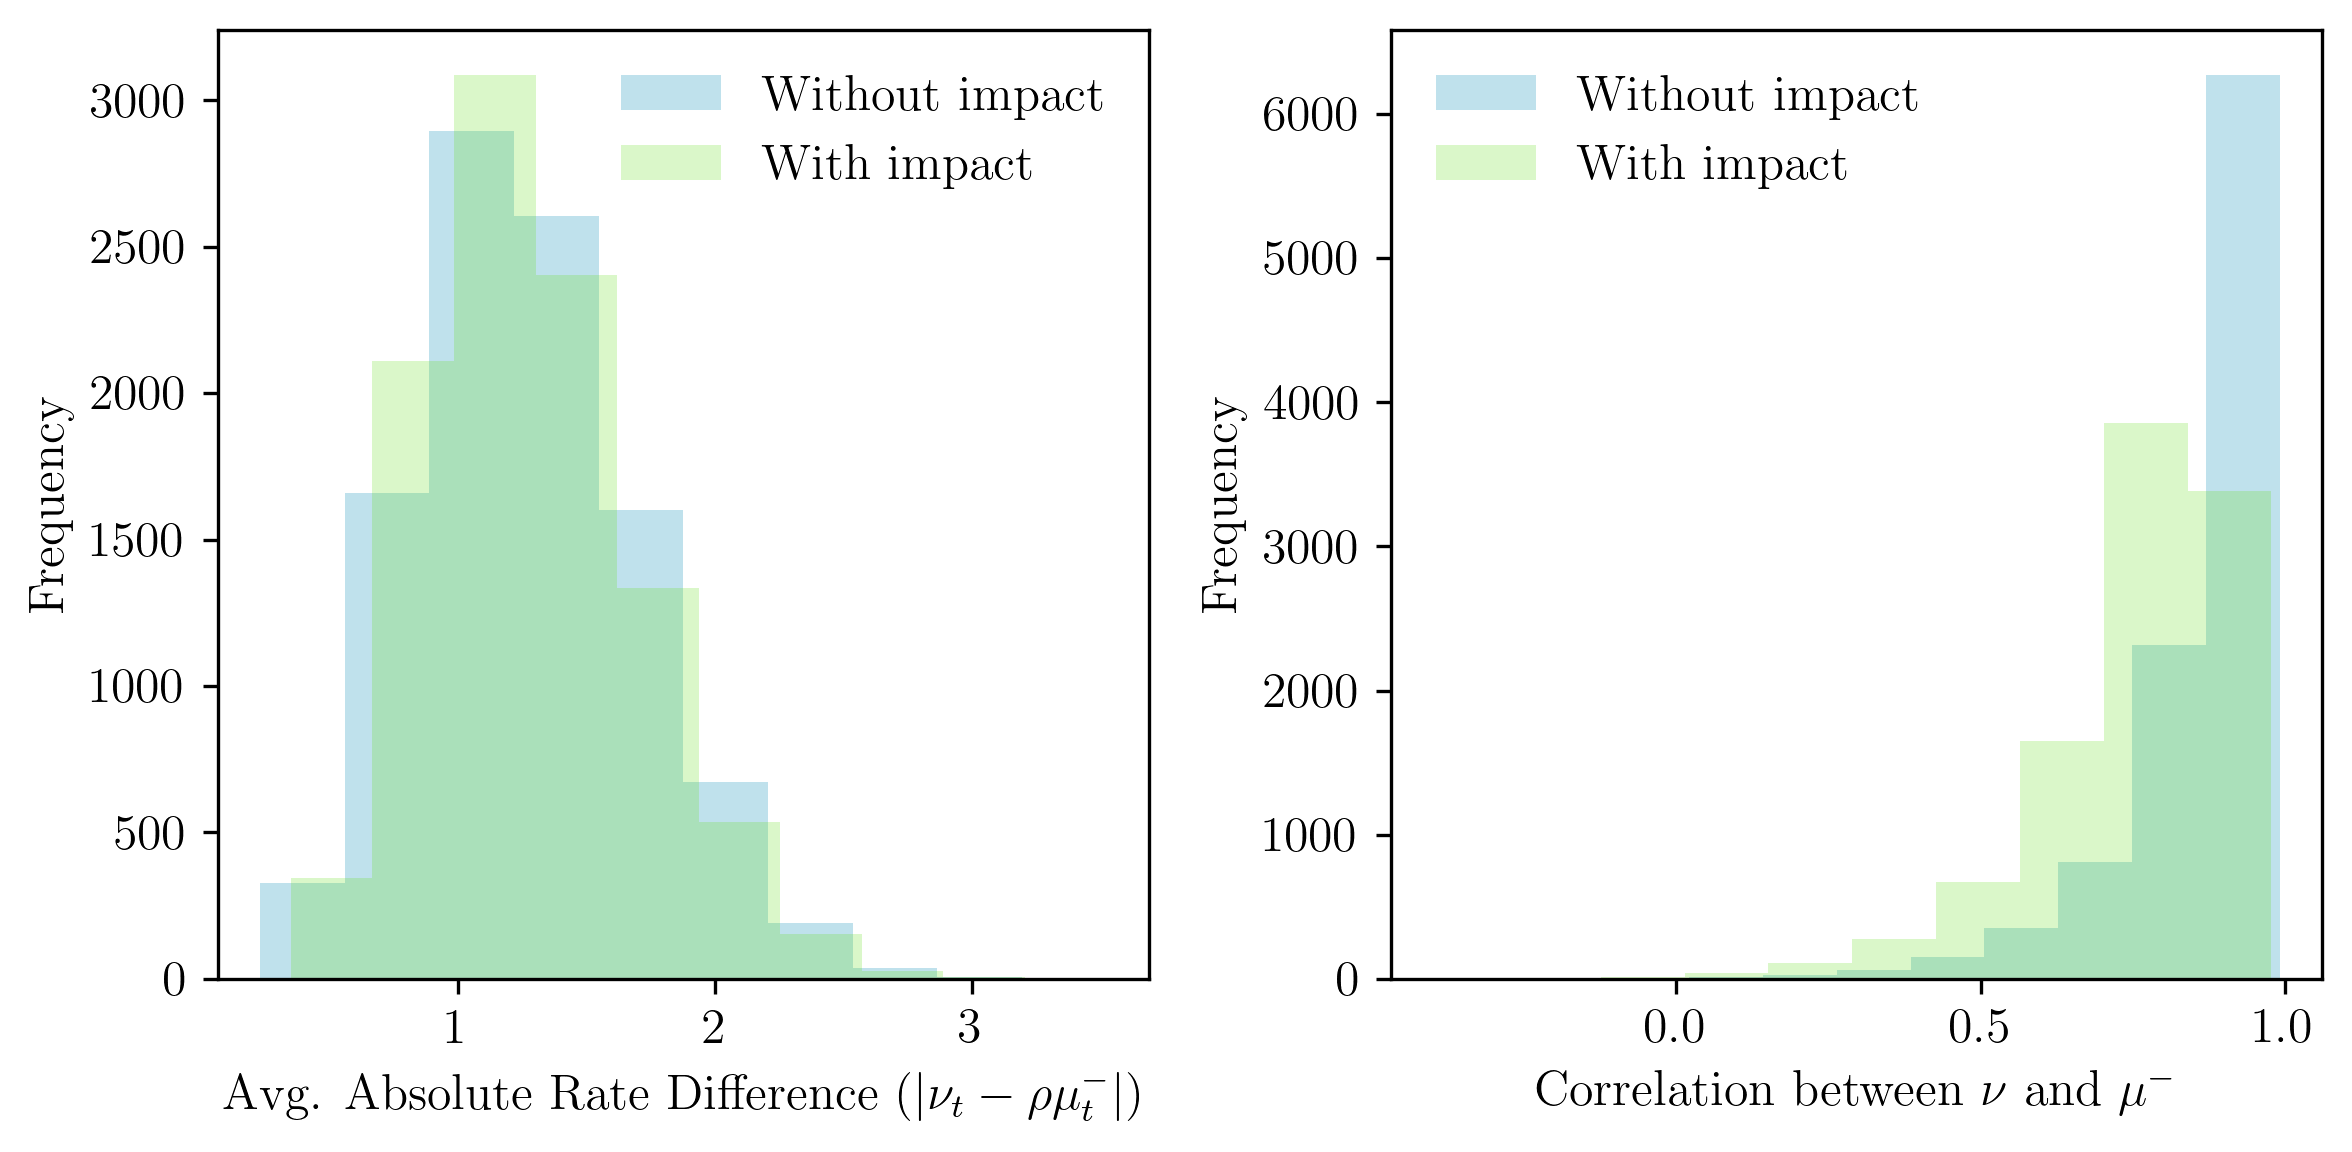

In [1203]:
dt = 1e-4  # Time interval
N = round(1 / dt) + 1  # Number of elements
S0 = 50  # Initial asset price
sigma = 0.5  # Price volatility
alpha = 1e6  # Terminal penalty coefficient
phi = 0.1  # Volume penalty coefficient
k = 0.1  # Temporary market impact
b = 0.1  # Permanent market impact
rho = 0.05  # Percentage of market volume to target
lmbda = 50  # Order flow rate parameter
kappa = 10  # Mean reversion rate
eta0 = 10  # Expected order flow magnitude

# Auxiliary parameters
zeta = calc_zeta2(alpha, b, phi, k)

t = np.arange(0, 1 + dt, dt)
avg_diff_orig_lst, avg_diff_impact_lst, corr_orig_lst, corr_impact_lst = [], [], [], []

num_samples = 10**4
for i in range(num_samples):
    # Generate noise processes
    W = generate_standard_brownian_motion(dt)
    mu_plus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=False)
    mu_minus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=False)
    mu = mu_plus - mu_minus

    # Compute state and control processes
    nu_orig, Q_orig = np.zeros(N), np.zeros(N)
    nu_impact, Q_impact = np.zeros(N), np.zeros(N)
    Q_orig[0] = 1
    Q_impact[0] = 1
    for j in range(N - 1):
        nu_orig[j] = optimal_rate_no_impact(t[j], Q_orig[j], mu_minus[j], rho, lmbda, b, phi, k, zeta, kappa, eta0)
        nu_impact[j] = optimal_rate_impact(t[j], Q_impact[j], mu_minus[j], mu[j], rho, lmbda, b, phi, k, zeta, kappa, eta0)
        Q_orig[j + 1] = Q_orig[j] - nu_orig[j] * dt
        Q_impact[j + 1] = Q_impact[j] - nu_impact[j] * dt
    nu_orig[-1] = nu_orig[-2]
    nu_impact[-1] = nu_impact[-2]
    
    # Compute average difference between the trading rate and the target rate (rho*mu_minus)
    avg_diff_orig = np.mean(np.abs(nu_orig - rho * mu_minus))
    avg_diff_impact = np.mean(np.abs(nu_impact - rho * mu_minus))
    avg_diff_orig_lst.append(avg_diff_orig)
    avg_diff_impact_lst.append(avg_diff_impact)
    
    # Compute correlations between trading rates and volume
    corr_orig, _ = scipy.stats.pearsonr(nu_orig, mu_minus)
    corr_impact, _ = scipy.stats.pearsonr(nu_impact, mu_minus)
    corr_orig_lst.append(corr_orig)
    corr_impact_lst.append(corr_impact)

# Print mean±std of histograms for each strategy
print('Average rate difference:')
print(f'Without impact: {np.array(avg_diff_orig_lst).mean():.6f}±{np.array(avg_diff_orig_lst).std():.6f}')
print(f'With impact: {np.array(avg_diff_impact_lst).mean():.6f}±{np.array(avg_diff_impact_lst).std():.6f}')
print('Average correlation:')
print(f'Without impact: {np.array(corr_orig_lst).mean():.6f}±{np.array(corr_orig_lst).std():.6f}')
print(f'With impact: {np.array(corr_impact_lst).mean():.6f}±{np.array(corr_impact_lst).std():.6f}')
    
# Visualize results
colors = ['#0088b5', '#6fe028']
fig = plt.figure(figsize=(8, 4), dpi=300)
ax1, ax2 = fig.subplots(1, 2)
ax1.hist(avg_diff_orig_lst, color=colors[0], alpha=0.25, label='Without impact')
ax1.hist(avg_diff_impact_lst, color=colors[1], alpha=0.25, label='With impact')
ax2.hist(corr_orig_lst, color=colors[0], alpha=0.25, label='Without impact')
ax2.hist(corr_impact_lst, color=colors[1], alpha=0.25, label='With impact')
ax1.set_xlabel('Avg. Absolute Rate Difference ($|\\nu_t - \\rho \mu_t^{-}|$)')
ax1.set_ylabel('Frequency')
ax2.set_xlabel('Correlation between $\\nu$ and $\mu^{-}$')
ax2.set_ylabel('Frequency')
ax1.legend(frameon=False)
ax2.legend(frameon=False)
fig.tight_layout()
fig.savefig('fig_2_2.svg')
plt.show()

### Simulation 3 - Comparing profits obtained by the various strategies

TWAP: -0.156733±0.753159
Without Impact: -0.115161±0.824395
With Impact: -0.050937±0.846275


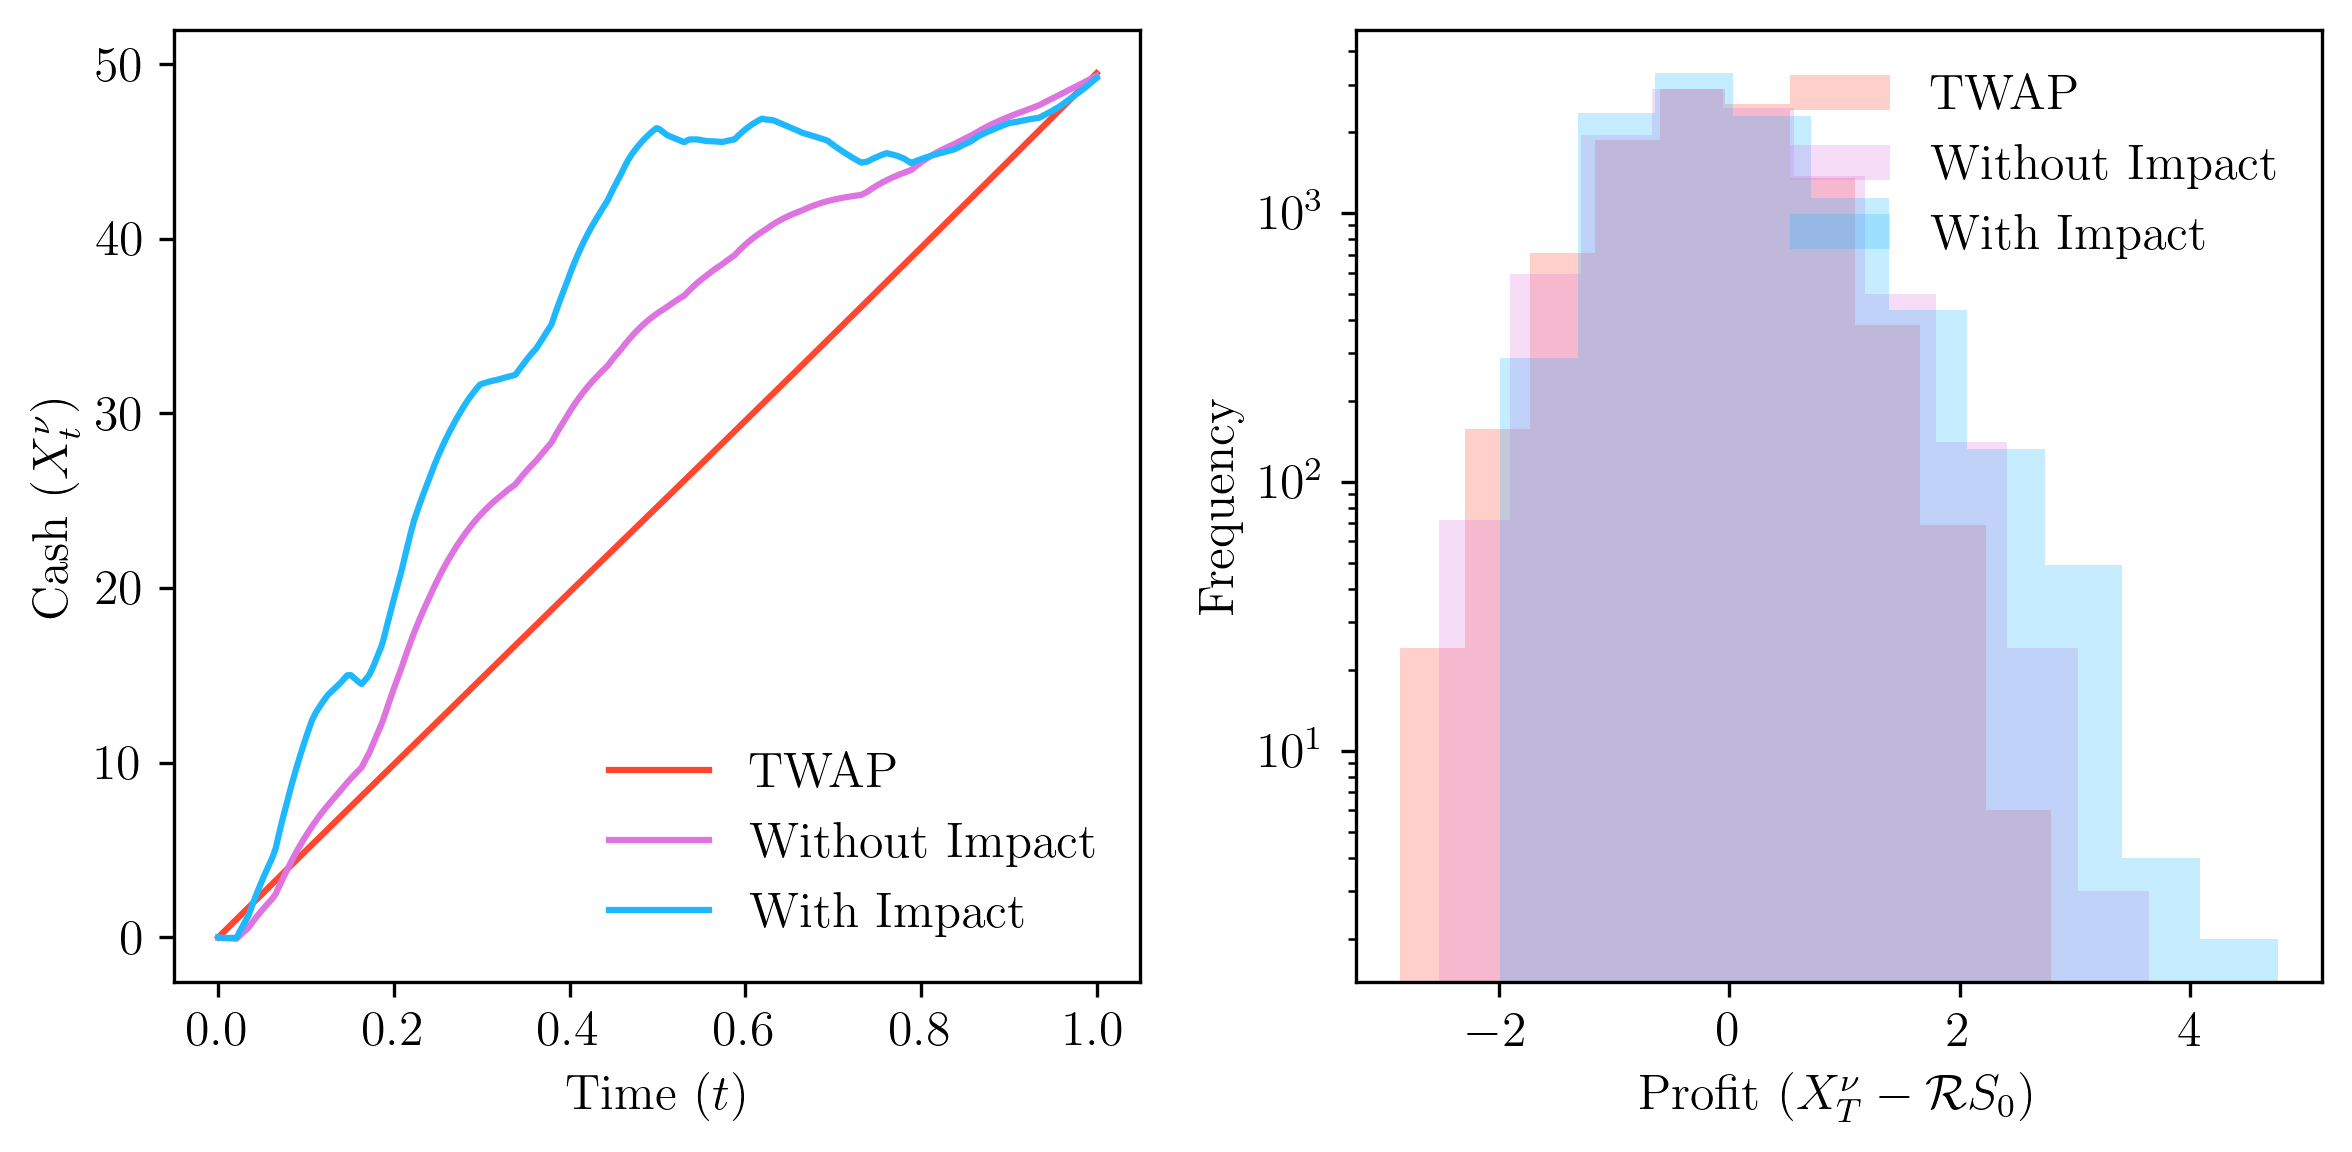

In [1204]:
dt = 1e-4  # Time interval
N = round(1 / dt) + 1  # Number of elements
S0 = 50  # Initial asset price
sigma = 0.5  # Price volatility
alpha = 1e6  # Terminal penalty coefficient
phi = 0.1  # Volume penalty coefficient
k = 0.1  # Temporary market impact
b = 0.1  # Permanent market impact
rho = 0.05  # Percentage of market volume to target
lmbda = 50  # Order flow rate parameter
kappa = 10  # Mean reversion rate
eta0 = 10  # Expected order flow magnitude

# Auxiliary parameters
zeta = calc_zeta2(alpha, b, phi, k)

t = np.arange(0, 1 + dt, dt)
P_twap_lst, P_orig_lst, P_impact_lst = [], [], []

# TWAP trading strategy
nu_twap = np.ones(len(t))

# Initialize figure
colors = ['#ff462e', '#dd74df', '#1fb8ff']
fig = plt.figure(figsize=(8, 4), dpi=300)
ax1, ax2 = fig.subplots(1, 2)

num_samples = 10**4
for i in range(num_samples):
    # Generate noise processes
    W = generate_standard_brownian_motion(dt)
    mu_plus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=False)
    mu_minus = generate_mean_reverting_jump(dt, lmbda, kappa, eta0=eta0, single=False)
    mu = mu_plus - mu_minus

    # Compute state and control processes
    nu_orig, Q_orig = np.zeros(N), np.zeros(N)
    nu_impact, Q_impact = np.zeros(N), np.zeros(N)
    Q_orig[0] = 1
    Q_impact[0] = 1
    for j in range(N - 1):
        nu_orig[j] = optimal_rate_no_impact(t[j], Q_orig[j], mu_minus[j], rho, lmbda, b, phi, k, zeta, kappa, eta0)
        nu_impact[j] = optimal_rate_impact(t[j], Q_impact[j], mu_minus[j], mu[j], rho, lmbda, b, phi, k, zeta, kappa, eta0)
        Q_orig[j + 1] = Q_orig[j] - nu_orig[j] * dt
        Q_impact[j + 1] = Q_impact[j] - nu_impact[j] * dt
    nu_orig[-1] = nu_orig[-2]
    nu_impact[-1] = nu_impact[-2]
        
    S_twap = S0 + sigma * W + b * np.cumsum(mu - nu_twap) * dt
    S_orig = S0 + sigma * W + b * np.cumsum(mu - nu_orig) * dt
    S_impact = S0 + sigma * W + b * np.cumsum(mu - nu_impact) * dt
    
    # Compute cash process for the various strategies
    X_twap = np.cumsum((S_twap - k * nu_twap) * nu_twap) * dt
    X_orig = np.cumsum((S_orig - k * nu_orig) * nu_orig) * dt
    X_impact = np.cumsum((S_impact - k * nu_impact) * nu_impact) * dt
    
    # Append profits to lists
    P_twap_lst.append(X_twap[-1] - S0)
    P_orig_lst.append(X_orig[-1] - S0)
    P_impact_lst.append(X_impact[-1] - S0)
      
    # Plot cash processes for a specific realization
    if i == 0:
        ax1.plot(t, X_twap, color=colors[0], label='TWAP')
        ax1.plot(t, X_orig, color=colors[1], label='Without Impact')
        ax1.plot(t, X_impact, color=colors[2], label='With Impact')

# Print mean±std of profit for each strategy
print(f'TWAP: {np.array(P_twap_lst).mean():.6f}±{np.array(P_twap_lst).std():.6f}')
print(f'Without Impact: {np.array(P_orig_lst).mean():.6f}±{np.array(P_orig_lst).std():.6f}')
print(f'With Impact: {np.array(P_impact_lst).mean():.6f}±{np.array(P_impact_lst).std():.6f}')
        
# Visualize results
ax2.hist(P_twap_lst, color=colors[0], alpha=0.25, label='TWAP')
ax2.hist(P_orig_lst, color=colors[1], alpha=0.25, label='Without Impact')
ax2.hist(P_impact_lst, color=colors[2], alpha=0.25, label='With Impact')
ax1.set_xlabel('Time ($t$)')
ax1.set_ylabel('Cash ($X_t^{\\nu}$)')
ax1.legend(frameon=False)
ax2.set_yscale('log')
ax2.set_xlabel('Profit ($X_T^{\\nu} - \mathcal{R}S_0$)')
ax2.set_ylabel('Frequency')
ax2.legend(frameon=False)
plt.tight_layout()
fig.savefig('fig_2_3.svg')
plt.show()